In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet
import lightning.pytorch as ptl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, Callback

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load and preprocess the data
mvtseries = pd.read_csv(
    "../assets/daily_multivariate_timeseries.csv",
    parse_dates=["datetime"],
    index_col="datetime",
)

In [ ]:
class MultivariateSeriesDataModule(ptl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        n_lags: int,
        horizon: int,
        test_size: float = 0.2,
        batch_size: int = 16,
    ):
        super().__init__()
        self.data = data
        self.feature_names = [col for col in data.columns if col != "Incoming Solar"]
        self.batch_size = batch_size
        self.test_size = test_size
        self.n_lags = n_lags
        self.horizon = horizon
        self.target_scaler = StandardScaler()
        self.training = None
        self.validation = None
        self.test = None
        self.predict_set = None
        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data["Incoming Solar"]
        self.data["time_index"] = np.arange(len(self.data))
        self.data["group_id"] = (
            0  # Assuming a single group for simplicity; adjust if needed
        )

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None):
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()

        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]

        # Scale the target variable
        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        train_df = train_df.drop("Incoming Solar", axis=1)
        val_df = val_df.drop("Incoming Solar", axis=1)
        test_df = test_df.drop("Incoming Solar", axis=1)

        # Setup datasets
        self.training = TimeSeriesDataSet(
            train_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=self.feature_names,
            scalers={name: StandardScaler() for name in self.feature_names},
        )
        self.validation = TimeSeriesDataSet.from_dataset(self.training, val_df)
        self.test = TimeSeriesDataSet.from_dataset(self.training, test_df)
        self.predict_set = TimeSeriesDataSet.from_dataset(
            self.training, self.data, predict=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict_set.to_dataloader(batch_size=1, shuffle=False)


In [ ]:
class LossTrackingCallback(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.logged_metrics.get("train_loss_epoch"):
            self.train_losses.append(trainer.logged_metrics["train_loss_epoch"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if trainer.logged_metrics.get("val_loss_epoch"):
            self.val_losses.append(trainer.logged_metrics["val_loss_epoch"].item())


In [ ]:
class ProbabilisticLSTM(ptl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, 1)  # Predictive mean
        self.fc_sigma = nn.Linear(hidden_size, 1)  # Predictive standard deviation
        self.hidden_size = hidden_size

        # Ensure that sigma is always positive
        self.softplus = nn.Softplus()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take last time step only
        mu = self.fc_mu(lstm_out)
        sigma = self.softplus(self.fc_sigma(lstm_out))
        return mu, sigma

    def training_step(self, batch, batch_idx):
        x, y = batch[0]["encoder_cont"], batch[1][0]
        mu, sigma = self.forward(x)
        dist = torch.distributions.Normal(mu, sigma)
        loss = -dist.log_prob(y).mean()
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return {"loss": loss, "log": {"train_loss": loss}}

    def validation_step(self, batch, batch_idx):
        x, y = batch[0]["encoder_cont"], batch[1][0]
        mu, sigma = self.forward(x)
        dist = torch.distributions.Normal(mu, sigma)
        loss = -dist.log_prob(y).mean()
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return {"val_loss": loss}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }


In [ ]:
def plot_losses(loss_tracking_callback):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    plt.plot(loss_tracking_callback.train_losses, label="Training Loss", color="blue")
    plt.plot(loss_tracking_callback.val_losses, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


hidden_size = 30
seq_len = 7

datamodule = MultivariateSeriesDataModule(
    data=mvtseries, n_lags=seq_len, horizon=seq_len * 2
)
datamodule.setup()

input_size = len(datamodule.feature_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ProbabilisticLSTM(input_size=input_size, hidden_size=hidden_size)


/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1712: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1712: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 5060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1712: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params | Mode  | FLOPs
------------------------------------------------------
0 | lstm     | LSTM     | 12.2 K | train | 0    
1 | fc_mu    | Linear   | 31     | train | 0    
2 | fc_sigma | Linear   | 31     | train | 0    
3 | softplus |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

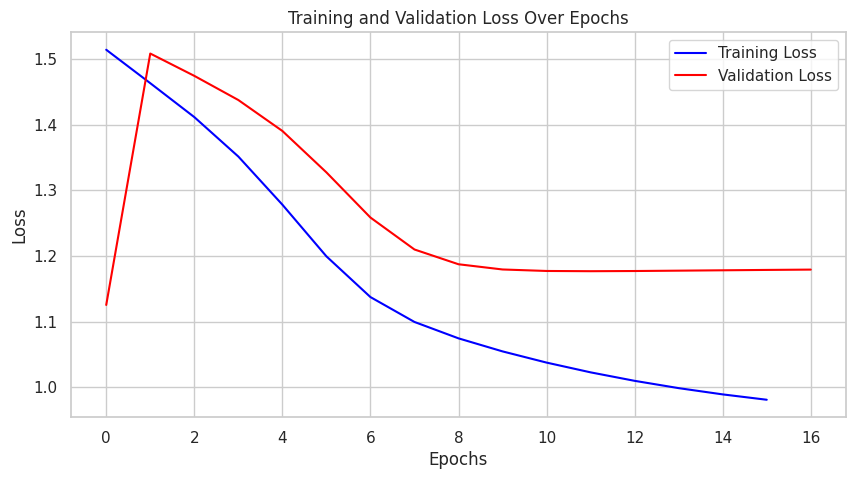

In [ ]:
# Add callbacks for early stopping and model checkpointing
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5)
checkpoint_callback = ModelCheckpoint(
    dirpath="./model_checkpoint/", save_top_k=1, monitor="val_loss"
)

loss_tracking_callback = LossTrackingCallback()

trainer = ptl.Trainer(
    max_epochs=100,
    callbacks=[early_stop_callback, checkpoint_callback, loss_tracking_callback],
)
trainer.fit(model, datamodule)

plot_losses(loss_tracking_callback)

# Load the best model and move it to the appropriate device
model = ProbabilisticLSTM.load_from_checkpoint(checkpoint_callback.best_model_path).to(
    device
)

model.eval()  # Set the model to evaluation mode
predictions = []
predictions_sigma = []
actuals = []

with torch.no_grad():
    for batch in datamodule.test_dataloader():
        x, y = batch
        x["encoder_cont"] = x["encoder_cont"].to(device)
        y = y[0].to(device)

        mu, sigma = model(x["encoder_cont"])
        mu = mu.squeeze().cpu().numpy()
        sigma = sigma.squeeze().cpu().numpy()
        y = y.squeeze().cpu().numpy()

        predictions.append(mu)
        predictions_sigma.append(sigma)
        actuals.append(y[:, 0])


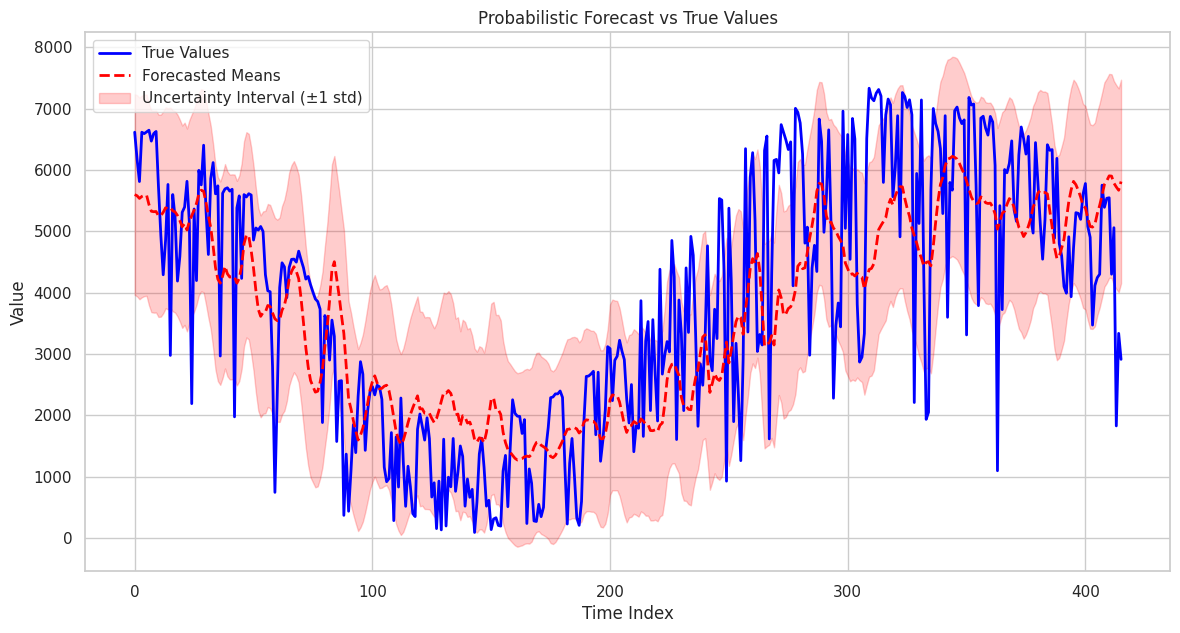

In [ ]:
# Convert predictions and actuals to numpy arrays
predictions = np.concatenate(predictions, axis=0)
predictions_sigma = np.concatenate(predictions_sigma, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Inverse transform the predictions
predictions = datamodule.target_scaler.inverse_transform(
    predictions.reshape(-1, 1)
).flatten()
predictions_sigma = (
    datamodule.target_scaler.scale_ * predictions_sigma
)  # Assuming the std deviations need rescaling
actuals = datamodule.target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()


def plot_probabilistic_forecasts(true_values, forecasted_means, forecasted_std):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 7))
    ax = plt.gca()

    time_index = np.arange(len(true_values))

    plt.plot(time_index, true_values, label="True Values", color="blue", linewidth=2)
    plt.plot(
        time_index,
        forecasted_means,
        label="Forecasted Means",
        color="red",
        linestyle="--",
        linewidth=2,
    )

    plt.fill_between(
        time_index,
        forecasted_means - forecasted_std,
        forecasted_means + forecasted_std,
        color="red",
        alpha=0.2,
        label="Uncertainty Interval (±1 std)",
    )

    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.title("Probabilistic Forecast vs True Values")
    plt.legend(loc="upper left")
    ax.grid(True)
    plt.show()


plot_probabilistic_forecasts(actuals, predictions, predictions_sigma)
